In [24]:
import numpy as np
from scipy.fft import rfft, rfftfreq, irfft

In [2]:
fftfreq?

Signature: fftfreq(n, d=1.0, *, xp=None, device=None)
Docstring:
Return the Discrete Fourier Transform sample frequencies.

The returned float array `f` contains the frequency bin centers in cycles
per unit of the sample spacing (with zero at the start).  For instance, if
the sample spacing is in seconds, then the frequency unit is cycles/second.

Given a window length `n` and a sample spacing `d`::

  f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
  f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

Parameters
----------
n : int
    Window length.
d : scalar, optional
    Sample spacing (inverse of the sampling rate). Defaults to 1.
xp : array_namespace, optional
    The namespace for the return array. Default is None, where NumPy is used.
device : device, optional
    The device for the return array.
    Only valid when `xp.fft.fftfreq` implements the device parameter.
 
Returns
-------
f : ndarray
    Array of length `n` containing the sample freq

In [4]:
rfftfreq?

Signature: rfftfreq(n, d=1.0, *, xp=None, device=None)
Docstring:
Return the Discrete Fourier Transform sample frequencies
(for usage with rfft, irfft).

The returned float array `f` contains the frequency bin centers in cycles
per unit of the sample spacing (with zero at the start).  For instance, if
the sample spacing is in seconds, then the frequency unit is cycles/second.

Given a window length `n` and a sample spacing `d`::

  f = [0, 1, ...,     n/2-1,     n/2] / (d*n)   if n is even
  f = [0, 1, ..., (n-1)/2-1, (n-1)/2] / (d*n)   if n is odd

Unlike `fftfreq` (but like `scipy.fftpack.rfftfreq`)
the Nyquist frequency component is considered to be positive.

Parameters
----------
n : int
    Window length.
d : scalar, optional
    Sample spacing (inverse of the sampling rate). Defaults to 1.
xp : array_namespace, optional
    The namespace for the return array. Default is None, where NumPy is used.
device : device, optional
    The device for the return array.
    Only valid when 

In [5]:
def frq(k, num, hz=1000):   # num is data length
    return k * hz / num


def ini_kc(fr, num, hz=1000):
    return int(np.ceil(fr * num / hz))


def fin_kc(fr, num, hz=1000):
    return int(np.floor(fr * num / hz))


def _partialFFT(arr, k0, k1, rmDC=True):   # 波数k0〜k1のFFT(k0, k1は自然数),  add rmDC=True
    num = len(arr)
    Fk = fft(arr) / num
    # Fk = fft(arr, norm="forward")      #Scipy ver.1.6以上
    if rmDC == True:     # add
        Fk[0] = 0             # add
    Fk[:k0] = 0           # index = 0, 1, 2, ... k0-1 の要素を0に (低振動数カット...左片側)
    Fk[num-k0+1:] = 0   # index = len(arr)-k1+1, len(arr)-k1+2, ... ,len(arr)-1 の要素を0に (低振動数カット....右片側)
    Fk[k1+1:num-k1] = 0   # index = k1+1, k1+2, ... len(arr)-(k1-1) の要素を0に （高周波数カット）
    return Fk


def partialFFT(arr, ini_frq, fin_frq, hz=1000, rmDC=True):    # add rmDC=True
    """
    Return 周波数範囲を指定したFFTスペクトル1D-ndarray.
    
    Parameters
    ----------
    arr : 1D-ndarray
        サンプリングデータ配列. 1D-ndarray.
    ini_frq : float
        低周波カットオフ周波数. ini_fr以上のスペクトルを残す.
    fin_frq : float
        高周波カットオフ周波数. fin_fr以下のスペクトルを残す.
    hz : int, optional (1000)
        サンプル周波数. デフォルトで1000[Hz].
    
    """
    num = len(arr)
    k0 = ini_kc(ini_frq, num, hz=hz)
    k1 = fin_kc(fin_frq, num, hz=hz)
    return  _partialFFT(arr, k0, k1, rmDC=rmDC)   # add rmDC=rmDC


def bpfilter(arr, ini_frq, fin_frq, hz=1000, rmDC=True):   # 周波数i区間[ini_frq, fin_frq]のバンドパスフィルター
    """
    Retern バンドパスフィルタを施した1D-ndarray(デフォルト). 
        
    Parameters
    ----------
    arr : 1D-ndarray
        サンプリングデータ配列. 1D-numpy配列.
    ini_frq : float
        低周波カットオフ周波数. ini_fr以上のスペクトルを残す.
    fin_frq : float
        高周波カットオフ周波数. fin_fr以下のスペクトルを残す.
    hz : int, optional (1000)
        サンプル周波数. デフォルトで1000[Hz].
    """
    num = len(arr)
    Fk = partialFFT(arr, ini_frq, fin_frq, hz=hz, rmDC=rmDC)    # add rmDC=rmDC
    return np.real(ifft(Fk) * num)
    # return np.real(ifft(Fk, norm="forward"))   #Scipy ver.1.6以上

In [6]:
fftfreq(30000, 1/1000)[12]

0.4

In [7]:
rfftfreq(30000, 1/1000)[12]

0.4

In [8]:
frq(12, 30000, hz=1000)

0.4

In [9]:
ini_kc(0.4, 30000, hz=1000)

12

In [10]:
fftfreq(30000, 1/1000)[1503]

50.1

In [11]:
rfftfreq(30000, 1/1000)[1503]

50.1

In [12]:
frq(1503, 30000, hz=1000)

50.1

In [13]:
fin_kc(50.1, 30000, hz=1000)

1503

In [14]:
fftfreq(30000, 1/1000)[1503]

50.1

In [15]:
rfftfreq(30000, 1/1000)[1503]

50.1

In [16]:
def nearestidx(arr, val):
    """
    Return int 
        データ配列arrからvalで指定したターゲット値に最も近い値のindex.
        
    Parameters
    ----------
    arr: 1D-ndarray
        データ配列
    val: float
        ターゲット値
    """
    return np.argmin(np.abs(arr - val))


In [17]:
nearestidx(rfftfreq(321321, 1/1000), 0.5)

161

In [18]:
ini_kc(0.5, 321321, hz=1000)

161

In [19]:
fin_kc(100, 321321, hz=1000)

32132

In [20]:
nearestidx(rfftfreq(321321, 1/1000), 100)

32132

In [21]:
nearestidx(rfftfreq(300, 1/1000), 2)

1

In [22]:
nearestidx(rfftfreq(300, 1/1000), 250)

75

In [23]:
ini_kc(2, 300, hz=1000)

1

In [26]:
def nearestidx(arr, val):
    """
    Return int 
        データ配列arrからvalで指定したターゲット値に最も近い値のindex.
        
    Parameters
    ----------
    arr: 1D-ndarray
        データ配列
    val: float
        ターゲット値
    """
    return np.argmin(np.abs(arr - val))


def partialFFT1(arr, ini_frq, fin_frq, hz=1000, rmDC=True):    # add rmDC=True
    """
    Return 周波数範囲を指定したFFTスペクトル1D-ndarray.
    
    Parameters
    ----------
    arr : 1D-ndarray
        サンプリングデータ配列. 1D-ndarray.
    ini_frq : float
        低周波カットオフ周波数. ini_fr以上のスペクトルを残す.
    fin_frq : float
        高周波カットオフ周波数. fin_fr以下のスペクトルを残す.
    hz : int, optional (1000)
        サンプル周波数. デフォルトで1000[Hz].
    
    """
    num = arr.size
    idx0 = nearestidx(rfftfreq(num, 1/hz), ini_frq)
    idx1 = nearestidx(rfftfreq(num, 1/hz), fin_frq)
    Fk = rfft(arr) / num
    # Fk = rfft(arr, norm="forward")      #Scipy ver.1.6以上
    if rmDC == True:
        Fk[0] = 0    # 直流成分カット
    Fk[:idx0] = 0           # index = 0, 1, 2, ... k0-1 の要素を0に (低振動数カット...左片側)
    # Fk[num-idx0+1:] = 0   # index = arr.size-k1+1, arr.size-k1+2, ... ,arr.size-1 の要素を0に (低振動数カット....右片側)
    # Fk[idx1+1:num-idx1] = 0   # index = k1+1, k1+2, ... arr.size-(k1-1) の要素を0に （高周波数カット）
    Fk[idx1+1:] = 0    # add: rfftを用いているので
    return Fk


def bpfilter1(arr, ini_frq, fin_frq, hz=1000, rmDC=True):   # 周波数i区間[ini_frq, fin_frq]のバンドパスフィルター
    """
    Retern バンドパスフィルタを施した1D-ndarray(デフォルト). 
        
    Parameters
    ----------
    arr : 1D-ndarray
        サンプリングデータ配列. 1D-numpy配列.
    ini_frq : float
        低周波カットオフ周波数. ini_fr以上のスペクトルを残す.
    fin_frq : float
        高周波カットオフ周波数. fin_fr以下のスペクトルを残す.
    hz : int, optional (1000)
        サンプル周波数. デフォルトで1000[Hz].
    """
    num = arr.size
    Fk = partialFFT1(arr, ini_frq, fin_frq, hz=hz, rmDC=rmDC)    # add rmDC=rmDC
    return np.real(irfft(Fk) * num)
    # return np.real(ifft(Fk, norm="forward"))   #Scipy ver.1.6以上


In [103]:
x = np.array([np.sin(2*np.pi*i/10000)+(1/10)*np.sin(2*np.pi*i/100)+np.random.normal(0, 0.05)+0.1*np.log(i+1) for i in range(10000)])

In [104]:
import matplotlib.pyplot as plt

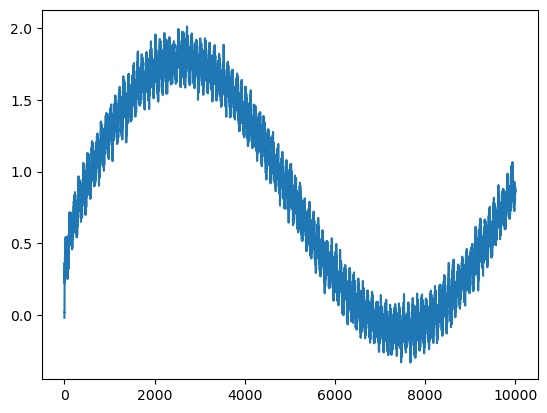

In [119]:
plt.plot(x)

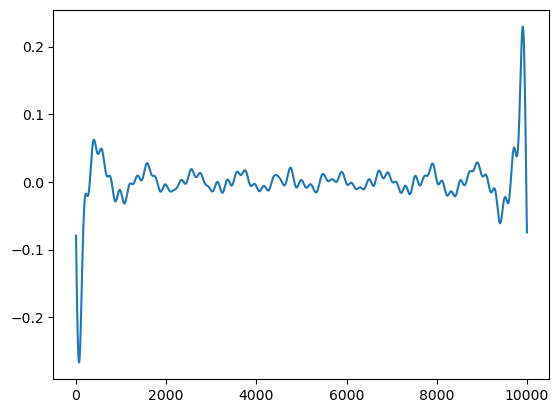

In [120]:
bpx1 = bpfilter(x, 1, 5)
plt.plot(bpx1)

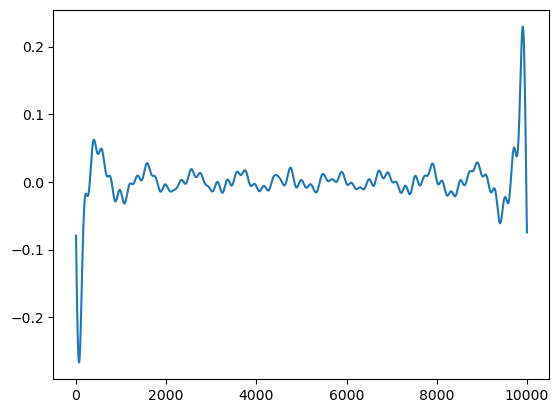

In [121]:
bpx2 = bpfilter1(x, 1, 5)
plt.plot(bpx2)

In [122]:
fx = partialFFT1(x, 10, 500)

In [123]:
fx.size

5001

In [124]:
fx

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , ..., -1.04636296e-03-0.00029345j,
        6.46236509e-05+0.00023986j, -3.78850046e-04+0.j        ])

In [125]:
fxx = partialFFT1(x, 10, 500, rmDC=False)

In [126]:
fxx

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , ..., -1.04636296e-03-0.00029345j,
        6.46236509e-05+0.00023986j, -3.78850046e-04+0.j        ])

In [131]:
for i, j in zip(fx, fxx):
    if i != j:
        print(f'i == {i}, j == {j}')
    else:
        pass

In [125]:
import matplotlib.pyplot as plt

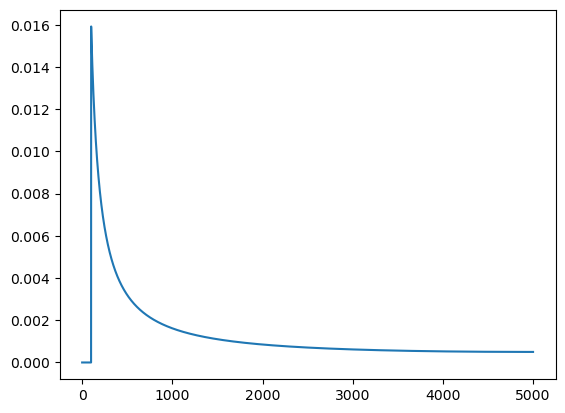

In [126]:
plt.plot(abs(fx))

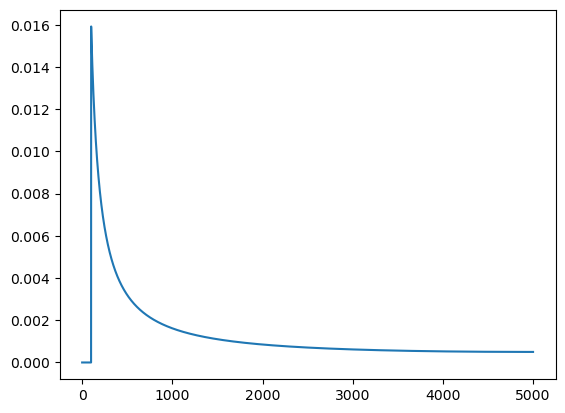

In [127]:
plt.plot(abs(fxx))

In [130]:
yy = np.array(list(range(10)))

In [131]:
yy

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [132]:
yy[3:20]

array([3, 4, 5, 6, 7, 8, 9])

In [133]:
yy[3:]

array([3, 4, 5, 6, 7, 8, 9])